In [1]:
# Semantic Networks
# Highly structured representations that are typically difficult to handle in connectionist architectures.
# Graph-like structure. 
# Nodes correspond to concepts, edges correspond to relations between concepts.
# Edges are labelled with a relation type.

# For our symbolic representation of a semantic network, we will use python dictionaries, mapping from a string giving the
# name of a concept to a python list specifying the relations belonging to the concept. The relations list contains 2-tuples, 
# one for each relation. The first element of each 2-tuple is a string giving the type of the relation, and the second is a 
# string giving the target of the relation.

isA = 'IsA'
partOf = 'PartOf'
relation_types = [isA, partOf]

semantic_network = {'Dog': [(isA, 'Canine'), (partOf, 'Pack')],
                    'Cat': [(isA, 'Feline'), (partOf, 'Clowder')],
                    'Pack': [],
                    'Clowder': [],
                    'Canine': [(isA, 'Mammal')],
                    'Feline': [(isA, 'Mammal')],
                    'Mammal': [],
                    }

print (semantic_network)

{'Dog': [('IsA', 'Canine'), ('PartOf', 'Pack')], 'Feline': [('IsA', 'Mammal')], 'Clowder': [], 'Mammal': [], 'Canine': [('IsA', 'Mammal')], 'Cat': [('IsA', 'Feline'), ('PartOf', 'Clowder')], 'Pack': []}


In [2]:
# Encoding Semantic Networks in Vectors: First Pass
# We'll use the circular convolution and vector addition operations provided by the SPA to construct an initial vector encoding 
# of the semantic network. Notice that we are not saying anything at all about neurons at this point; we'll stick to vectors 
# for the time being and worry about neurons in a little bit. For this first pass, we will use the most straightforward approach 
# for vector encoding a semantic network, however, as we'll see, it can only be used on semantic networks that do not have 
# directed cycles. We'll see how to fix this later.

# Perform topological sort on concepts in the semantic network. If we assign vectors to concepts in the returned order,
# then whenever we assign a vector to a concept, all concepts that it depends on will already have been assigned vectors.
from nengo.utils.graphs import toposort, reverse_edges
adj_semantic_network = {key: [r[1] for r in rels] for (key, rels) in semantic_network.items()}
rev_semantic_network = reverse_edges(adj_semantic_network)

try:
    order = toposort(rev_semantic_network)
except ValueError:
    raise Exception("Error: Semantic network has directed cycles")

print (semantic_network)
print (adj_semantic_network)
print (rev_semantic_network)

{'Dog': [('IsA', 'Canine'), ('PartOf', 'Pack')], 'Feline': [('IsA', 'Mammal')], 'Clowder': [], 'Mammal': [], 'Canine': [('IsA', 'Mammal')], 'Cat': [('IsA', 'Feline'), ('PartOf', 'Clowder')], 'Pack': []}
{'Mammal': [], 'Feline': ['Mammal'], 'Clowder': [], 'Canine': ['Mammal'], 'Dog': ['Canine', 'Pack'], 'Cat': ['Feline', 'Clowder'], 'Pack': []}
{'Mammal': ('Feline', 'Canine'), 'Feline': ('Cat',), 'Pack': ('Dog',), 'Clowder': ('Cat',), 'Canine': ('Dog',)}


In [3]:
from nengo.spa import Vocabulary
from nengo.spa.pointer import SemanticPointer

# Pick a dimension for our vectors. Higher dimensions generally provide a more accurate encoding,
# but also require more neural resources.
D = 16       #  128

# Create a vocabulary, which stores semantic pointers and lets us access them by name
sp_vocab = Vocabulary(D)
relation_type_vocab = Vocabulary(D)

# Assign random unit vectors to the relation types
for rt in relation_types:
    relation_type_vocab.parse(rt)

# Create semantic pointers that store the relational structure for each concept
for concept in order:
    semantic_pointer = SemanticPointer(D)

    for relation in semantic_network[concept]:
        rt = relation_type_vocab.parse(relation[0])
        sp = sp_vocab.parse(relation[1])
        semantic_pointer += rt * sp

    semantic_pointer.normalize()

    sp_vocab.add(concept, semantic_pointer)

In [4]:
# Now that we have this vector encoding of the semantic network, lets play around with it a bit and see what it gives us. 
# In particular, lets see what Cat⊛(PartOf)−1 gives us.

cat_vector = sp_vocab.parse('Cat')
partOf_vector = relation_type_vocab.parse('PartOf')

result = cat_vector * ~partOf_vector

# Cosine similariy each of the SP's in the vocab to result. Pair each with its name.
similarities = [(key, result.compare( sp_vocab.parse(key) ) ) for key in sp_vocab.keys]

# Calculate the SP with the highest similarity to result
closest = max(similarities, key=lambda pair:pair[1])

print (similarities)
print (closest)

# Cool! Cat⊛(PartOf)−1 is closest to Clowder, just as we'd expect. So we have a way of approximately traversing the edges in 
# the semantic network using operations on vectors.

[('Mammal', -0.11452716757343863), ('Feline', -0.1837569495601892), ('Pack', 0.10876304069894656), ('Clowder', 0.6104273007090153), ('Canine', -0.19877502286852694), ('Cat', 0.077088079265912171), ('Dog', -0.53366566505315483)]
('Clowder', 0.6104273007090153)


In [5]:
# Now, in particular, lets see what Dog⊛(PartOf)−1 gives us.

dog_vector = sp_vocab.parse('Dog')
partOf_vector = relation_type_vocab.parse('PartOf')

result = dog_vector * ~partOf_vector

# Cosine similariy each of the SP's in the vocab to result. Pair each with its name.
similarities = [(key, result.compare( sp_vocab.parse(key) ) ) for key in sp_vocab.keys]

# Calculate the SP with the highest similarity to result
closest = max(similarities, key=lambda pair:pair[1])

print (similarities)
print (closest)

# Cool! Dog⊛(PartOf)−1 is closest to Pack.

[('Mammal', -0.057301018422400034), ('Feline', 0.28741481552748438), ('Pack', 0.66811751693918897), ('Clowder', 0.16601755733532239), ('Canine', 0.3853296914099491), ('Cat', -0.032749863579141184), ('Dog', 0.13227238474620553)]
('Pack', 0.66811751693918897)


In [6]:
# Now, in particular, lets see what Canine⊛(isA)−1 gives us.

canine_vector = sp_vocab.parse('Canine')
isA_vector = relation_type_vocab.parse('IsA')

result = canine_vector * ~isA_vector

# Cosine similariy each of the SP's in the vocab to result. Pair each with its name.
similarities = [(key, result.compare( sp_vocab.parse(key) ) ) for key in sp_vocab.keys]

# Calculate the SP with the highest similarity to result
closest = max(similarities, key=lambda pair:pair[1])

print (similarities)
print (closest)

# Cool! Canine⊛(isA)−1 is closest to Mammal

[('Mammal', 0.80257789464066298), ('Feline', 0.28550395776230186), ('Pack', 0.020659320781777978), ('Clowder', 0.14053978326025998), ('Canine', 0.57341424301652333), ('Cat', 0.055857481541477481), ('Dog', 0.29146132972187205)]
('Mammal', 0.80257789464066298)


c:\nengo\nengo\base.py:59: SyntaxWarning: Creating new attribute 'vocab' on '<Node "input">'. Did you mean to change an existing attribute?
  SyntaxWarning)
c:\nengo\nengo\base.py:59: SyntaxWarning: Creating new attribute 'vocab' on '<Node "output">'. Did you mean to change an existing attribute?
  SyntaxWarning)


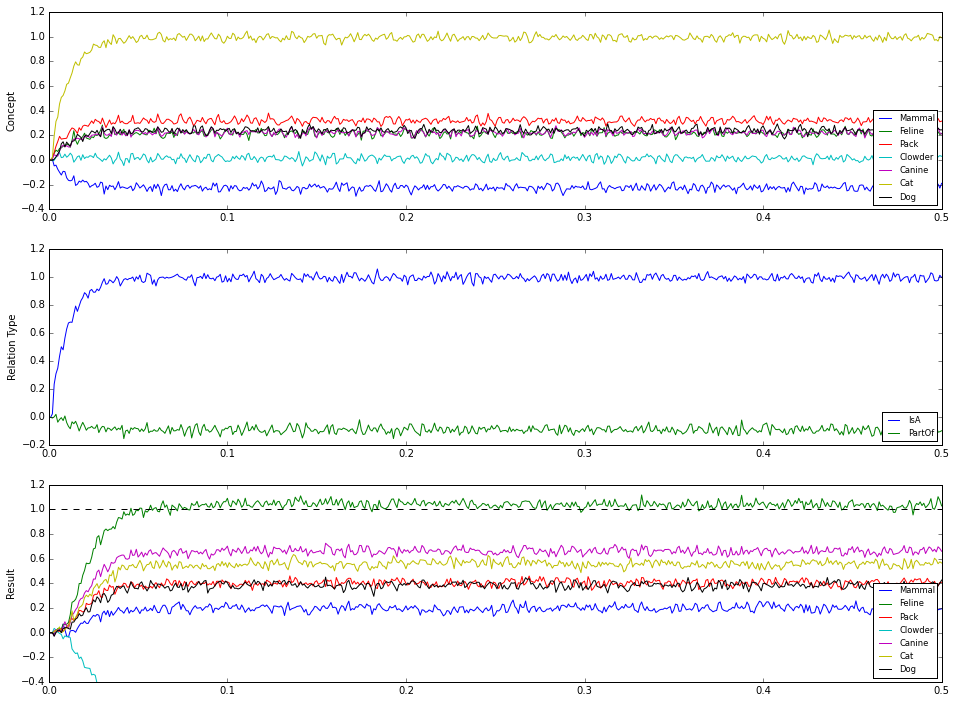

In [7]:
# Now, we know that the Semantic Pointer Architecture provides us with handy tools that permit us to implement these operations 
# in a spiking neural network. So lets see how that would look:

# Import the tools we'll need
import nengo
import nengo.spa as spa
from nengo.networks import CircularConvolution

n_neurons = 50     # 50 # number of neurons per dimension

model = spa.SPA(label="Semantic Network Traversal")

with model:
    # Define to SPA buffers representing the concept SP and the query SP, respectively.
    model.concept = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=sp_vocab)

    model.relation_type = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=relation_type_vocab)

    # Give these two buffers appropriate input
    def concept_input(t):
        #sequence = 'Canine Feline Dog Cat Dog'.split()
        sequence = 'Cat Cat Cat Cat Cat'.split()
        index = int(t / 0.1) % len(sequence)
        return sequence[index]
    
    def relation_type_input(t):
        #sequence = 'IsA IsA PartOf PartOf IsA'.split()
        #sequence = 'PartOf PartOf PartOf PartOf PartOf'.split()
        sequence = 'IsA IsA IsA IsA IsA'.split()
        index = int(t / 0.1) % len(sequence)
        return sequence[index]

    model.input = spa.Input(concept=concept_input, relation_type=relation_type_input)

    # Define a group of neurons to perform circular convolution, and
    # another group of neurons to project the results to.
    
    # Note that we set invert_b=True, so that involution is performed on
    # the query vector.
    model.cconv = CircularConvolution(
        n_neurons=n_neurons, dimensions=D, invert_b=True, radius=0.4)

    model.result = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=sp_vocab)

    # Connect everything up.
    nengo.Connection(model.concept.state.output, model.cconv.A)
    nengo.Connection(model.relation_type.state.output, model.cconv.B)
    nengo.Connection(model.cconv.output, model.result.state.input)

    # Probe to get the results of the simulation
    synapse = 0.01
    concept = nengo.Probe(model.concept.state.output, synapse=synapse)
    relation_type = nengo.Probe(model.relation_type.state.output, synapse=synapse)
    result = nengo.Probe(model.result.state.output, synapse=synapse)

# Simulate the model
sim = nengo.Simulator(model)
sim.run(0.5)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 1)

fontsize = 'small'

fig = plt.figure(figsize=(16, 12))

p1 = fig.add_subplot(gs[0, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, concept))
p1.legend(concept.target.vocab.keys, fontsize=fontsize, loc=4)
p1.set_ylabel('Concept')

p1 = fig.add_subplot(gs[1, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, relation_type))
p1.legend(relation_type.target.vocab.keys, fontsize=fontsize, loc=4)
p1.set_ylabel('Relation Type')

p1 = fig.add_subplot(gs[2, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, result))
p1.legend(result.target.vocab.keys, fontsize=fontsize, loc=4)
p1.axhline(y=1.0, ls='--', c='k')
p1.set_ylim((-0.4, 1.2))
p1.set_ylabel('Result')

In [8]:
# Improving performance with a Cleanup Memory
# So the returned vector is always most similar to the vector we'd want it to be similar to. For example, when the input is 
# Dog and PartOf, the returned vector is most similar to Pack. This is good, but not quite good enough. We'd like the the 
# similarity of the returned vector and the correct vector to be as close to 1.0 as possible. 
# If this is not the case, then these errors will pile up, and make the network useless for doing complex tasks like 
# hierarchical inference, or traverse paths through the semantic network.

# To fix this, we run the output through what is known as a cleanup memory. This is essentially a fast, feedforward auto-associative 
# memory. First lets try it in the abstract case, without neurons:

cat_vector = sp_vocab.parse('Cat')
partOf_vector = relation_type_vocab.parse('PartOf')

result = cat_vector * ~partOf_vector
similarities = [(key, result.compare( sp_vocab.parse(key) ) ) for key in sp_vocab.keys]

closest = max(similarities, key=lambda pair:pair[1])

print ("Closest before cleanup:")
print (closest)

import numpy as np
sum = np.zeros(D)
threshold = 0.3

for key in sp_vocab.keys:
    sp = sp_vocab.parse(key)
    similarity = np.dot(sp.v, result.v)
    scale = 1.0 if similarity > threshold else 0.0
    sum += scale * sp.v
    
sum = SemanticPointer(data=sum)
                      
similarities = [(key, sum.compare( sp_vocab.parse(key) ) ) for key in sp_vocab.keys]
closest = max(similarities, key=lambda pair:pair[1])

print ("Closest after cleanup:")
print (closest)


Closest before cleanup:
('Clowder', 0.6104273007090153)
Closest after cleanup:
('Clowder', 1.0000000000000002)


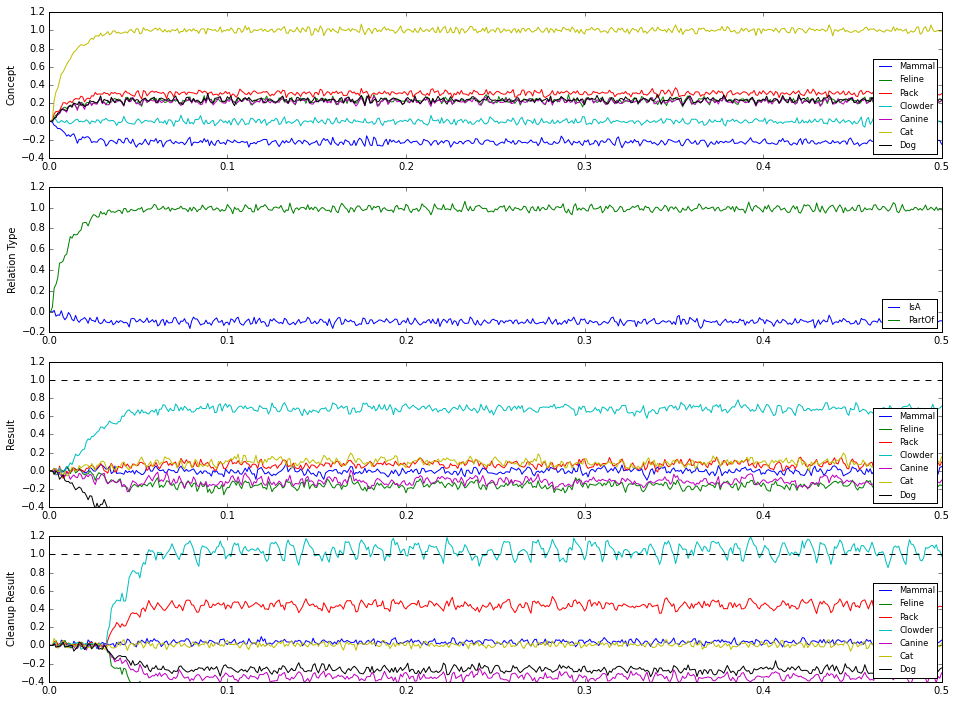

In [9]:
# The SPA module provides us with a neural implementation of algorithm. It is implemented by the Associative Memory class.
# The Associative Memory class can implement a bunch of different association functionality, but we get a cleanup memory 
# when we only supply one vocabulary (i.e. when we want to associate vectors with themselves).

# Import the tools we'll need
import nengo
import nengo.spa as spa
from nengo.networks import CircularConvolution
from nengo.spa.assoc_mem import AssociativeMemory

n_neurons = 50           # 50 # number of neurons per dimension
n_cleanup_neurons = 20    # 20 # number of neurons per item in vocabulary

model = spa.SPA(label="Semantic Network Traversal")

with model:
    # --------------Everything at the start is the same-----------------
    model.concept = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=sp_vocab)

    model.relation_type = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=relation_type_vocab)

    def concept_input(t):
        #sequence = 'Canine Feline Dog Cat Dog'.split()
        sequence = 'Cat Cat Cat Cat Cat'.split()        
        index = int(t / 0.1) % len(sequence)
        return sequence[index]
    
    def relation_type_input(t):
        #sequence = 'IsA IsA PartOf PartOf IsA'.split()
        #sequence = 'IsA IsA IsA IsA IsA'.split()
        sequence = 'PartOf PartOf PartOf PartOf PartOf'.split()
        index = int(t / 0.1) % len(sequence)
        return sequence[index]

    model.input = spa.Input(concept=concept_input, relation_type=relation_type_input)

    model.cconv = CircularConvolution(
        n_neurons=n_neurons, dimensions=D, invert_b=True, radius=0.6)

    model.result = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=sp_vocab)

    # Connect everything up.
    nengo.Connection(model.concept.state.output, model.cconv.A)
    nengo.Connection(model.relation_type.state.output, model.cconv.B)
    nengo.Connection(model.cconv.output, model.result.state.input)

    # Probe to get the results of the simulation
    synapse = 0.01
    concept = nengo.Probe(model.concept.state.output, synapse=synapse)
    relation_type = nengo.Probe(model.relation_type.state.output, synapse=synapse)
    result = nengo.Probe(model.result.state.output, synapse=synapse)

    # ---------- Now add on a cleanup memory -------------------------
    model.associative_memory = AssociativeMemory(
        input_vocab=sp_vocab, n_neurons_per_ensemble=n_cleanup_neurons, threshold=0.3)
    
    model.cleanup_result = spa.Buffer(
        dimensions=D, subdimensions=1, neurons_per_dimension=n_neurons,
        vocab=sp_vocab)
    
    # Connect up the cleanup memory
    nengo.Connection(model.result.state.output, model.associative_memory.input)
    nengo.Connection(model.associative_memory.output, model.cleanup_result.state.input)

    # And probe it
    cleanup_result = nengo.Probe(model.cleanup_result.state.output, synapse=synapse)

# Simulate the model
sim = nengo.Simulator(model)
sim.run(0.5)

# Plot results, showing how the cleanup memory improves performance.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(4, 1)
fontsize = 'small'
fig = plt.figure(figsize=(16, 12))

p1 = fig.add_subplot(gs[0, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, concept))
p1.legend(concept.target.vocab.keys, fontsize=fontsize, loc=4)
p1.set_ylabel('Concept')

p1 = fig.add_subplot(gs[1, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, relation_type))
p1.legend(relation_type.target.vocab.keys, fontsize=fontsize, loc=4)
p1.set_ylabel('Relation Type')

p1 = fig.add_subplot(gs[2, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, result))
p1.legend(result.target.vocab.keys, fontsize=fontsize, loc=4)
p1.axhline(y=1.0, ls='--', c='k')
p1.set_ylim((-0.4, 1.2))
p1.set_ylabel('Result')

p1 = fig.add_subplot(gs[3, 0])
p1.plot(sim.trange(), spa.similarity(sim.data, cleanup_result))
p1.legend(cleanup_result.target.vocab.keys, fontsize=fontsize, loc=4)
p1.axhline(y=1.0, ls='--', c='k')
p1.set_ylim((-0.4, 1.2))
p1.set_ylabel('Cleanup Result')